# Кодирование и обучение в спайковых нейронных сетях
В этой домашней работе нужно сравнить две способа кодирования информации: частотный и временной.

## Задание
* Сгенерируйте обучающую и тестовую выборки простых изображений размером 3 на 3 пикселя
* Реализуйте два типа кодирования: частотой спайков и временем до первого спайка (TTFS). Использовать ноутбук к семинару про кодирование.  
* Обучите две сети по правилу STDP. Архитектуру сети можно взять из семинара по классификации. Вероятно, придется выбрать разные значения параметров для правила STDP.
* Сравните качество классификации по метрикам accuracy и F-measure

## References

[1] Diehl, P. U., & Cook, M. (2015). Unsupervised learning of digit recognition using spike-timing-dependent plasticity. Frontiers in computational neuroscience, 9, 99 

[2] https://www.kaggle.com/code/dlarionov/mnist-spiking-neural-network/notebook

In [1]:
!pip install brian2
!pip install --upgrade numpy
!pip install --upgrade matplotlib


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import brian2 as b2
import numpy as np

## Генерация данных
* Сгенерируем эталонные картинки - образцы классов
* Сгенерируем набор зашумленных картинок
* Разобьем на обучающую и тестовую выборки

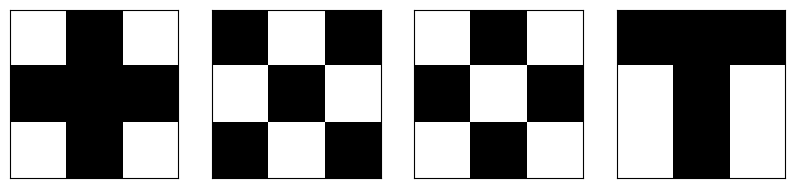

In [3]:
def draw_patterns(patterns):
    fig, ax = plt.subplots(nrows = 1, ncols = len(patterns), figsize=(10,5))
    for i,p in enumerate(patterns):
        ax[i].imshow(patterns[i], cmap='Greys')
        ax[i].tick_params(axis='both', labelbottom=False, labeltop=False, labelleft=False, labelright=False,
                                bottom=False, top=False, left=False, right=False)

t1 = np.array([0, 1, 0,
                 1, 1, 1,
                 0, 1, 0]).reshape(3,3)
t2 = np.array([1, 0, 1,
                  0, 1, 0,
                  1, 0, 1]).reshape(3,3)
t3 = np.array([0, 1, 0,
                  1, 0, 1,
                  0, 1, 0]).reshape(3,3)
t4 = np.array([1, 1, 1,
                  0, 1, 0,
                  0, 1, 0]).reshape(3,3)
patterns = [t1, t2, t3, t4]
draw_patterns(patterns)

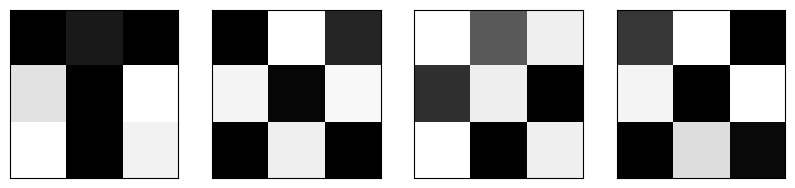

In [4]:
N_SAMPLE_CLASS = 60
rng = np.random.default_rng()
X, y = [], []
sigma = 0.2
for i_p, p in enumerate(patterns):
    for _ in range(N_SAMPLE_CLASS):
        X += [np.clip(p + sigma*rng.standard_normal(p.shape), 0, 1)]
        y += [i_p]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
draw_patterns(X_train[:4])

# Частотное кодирование
Яркость пикселя $r_i$ преобразуется в частоту спайков
$$
\lambda_i=r_i\lambda_{max}
$$

## Создаем сеть
* Входной слой, кол-во нейронов равно кол-ву пикселей
* Выходной слой, кол-во нейронов должно быть не меньше кол-ва классов
* STDP синапсы
* Синапсы латерального торможения

In [ ]:
taum = 10*b2.ms
taue = 5*b2.ms
taui = 10*b2.ms
v_rest = -74*b2.mV
vt = -54*b2.mV
vr = -60*b2.mV
Ee = 0*b2.mV
Ei = -100*b2.mV

def create_input(size):
    input_group = b2.PoissonGroup(size, rates=np.zeros(size)*b2.Hz, name='InG')
    s_mon_inp = b2.SpikeMonitor(input_group)
    return input_group, s_mon_inp

def create_exc_neurons(size):
    neuron_eq = '''
                dv/dt = (v_rest - v + ge * (Ee - v) + gi * (Ei - v)) / taum : volt
                dge/dt = -ge / taue : 1
                dgi/dt = -gi / taui : 1
                '''
    neurons = b2.NeuronGroup(size, neuron_eq, threshold='v>vt', reset='v = vr',
                        method='euler')
    neurons.v = v_rest
    neurons.ge=0
    neurons.gi=0
    s_mon_nrn = b2.SpikeMonitor(neurons)
    return neurons, s_mon_nrn

taupre=20*b2.ms
taupost=20*b2.ms
gmax=0.25
gi_max = gmax
max_delay_i = 10*b2.ms
dApre=0.01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

def create_stdp_synapses(pre_group, post_group):
    S = b2.Synapses(pre_group, post_group,
                '''w : 1
                    stdp_rate : 1 (shared)
                    dApre/dt = -Apre / taupre : 1 (event-driven)
                    dApost/dt = -Apost / taupost : 1 (event-driven)''',
                on_pre='''ge += w
                        Apre += dApre
                        w = clip(w + stdp_rate*Apost, 0, gmax)''',
                on_post='''Apost += dApost
                        w = clip(w + stdp_rate*Apre, 0, gmax)''',
                )
    S.connect()
    S.w = 'rand() * gmax'
    S.stdp_rate = 1
    mon = b2.StateMonitor(S, 'w', record=True)
    return S, mon

def create_inh_synapses(neuron_group):
    S = b2.Synapses(neuron_group, neuron_group,
                '''w : 1
                    ''',
                on_pre='''gi += w''',
                )
    S.connect('i!=j')
    S.delay = "max_delay_i*rand()"
    S.w = gi_max  
    return S

def weights_norming(stdp_synapses, img_size):
    w_sum_avg = []
    for i in range(img_size):
        w_sum_avg.append(sum(stdp_synapses.w[:, i])/len(stdp_synapses.w[:, i]))
    max_avg_sum = max(w_sum_avg)
    for i in range(img_size):
        stdp_synapses.w[:, i] = stdp_synapses.w[:, i] * max_avg_sum / w_sum_avg[i]
    stdp_synapses.w = 5 * gmax * stdp_synapses.w
    return stdp_synapses

In [ ]:
b2.start_scope()
input_layer, mon_input = create_input(patterns[0].size)
exc_layer, mon_exc = create_exc_neurons(5*len(patterns))
stdp_synapses, mon_stdp = create_stdp_synapses(input_layer, exc_layer)
stdp_synapses = weights_norming(stdp_synapses, patterns[0].size)
inh_synapses = create_inh_synapses(exc_layer)
b2.run(0*b2.ms)
#b2.store()

Input layer: 9 neurons
Excitatory layer: 20 neurons
180 STDP synapses
380 inhibitory synapses


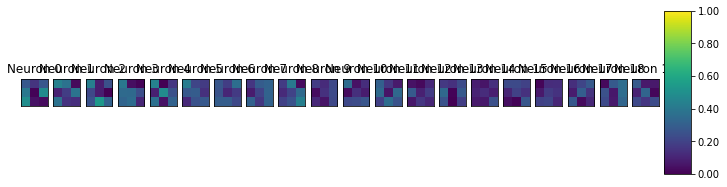

In [ ]:
def plot_synapses(n_source, n_target, synapses, title=""):
    plt.figure(figsize=(3,3))
    W = np.full((n_source, n_target), np.nan)
    W[synapses.i[:], synapses.j[:]] = synapses.w[:]
    plt.imshow(W)
    plt.yticks(synapses.i)
    plt.xticks(synapses.j)
    plt.title(title)
    plt.xlabel("Target")
    plt.ylabel("Source")
    plt.colorbar(format="%4.2f")

def plot_input_synapses(synapses):
    fig,ax = plt.subplots(nrows=1, ncols=len(synapses.target)+1, figsize=(12,3))
    for j in range(len(synapses.target)):
        im = ax[j].imshow(np.reshape(synapses.w[:,j], (3,3)), vmin=0, vmax=1)
        ax[j].set_xticks([])
        ax[j].set_yticks([])
        ax[j].set_title(f"Neuron {j}")
    fig.colorbar(im, cax = ax[-1], format="%4.2f")

print(f"Input layer: {len(input_layer)} neurons")
print(f"Excitatory layer: {len(exc_layer)} neurons")
print(f"{len(stdp_synapses)} STDP synapses")
print(f"{len(inh_synapses)} inhibitory synapses")
plot_input_synapses(stdp_synapses)

## Обучение сети
Последовательно предъявляем все образы из обучающей выборки. Каждый образ предъявляется в течение T=150 мс. 

Training STDP weights has finished!


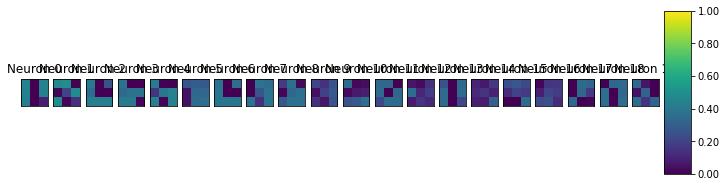

In [ ]:
max_rate = 120*b2.Hz
T_img = 150*b2.ms
T_rest = 50*b2.ms
for img in X_train:
    input_layer.rates = img.ravel()*max_rate
    b2.run(T_img, report=None)
    input_layer.rates = img.ravel()*0*b2.Hz
    b2.run(T_rest, report=None)
print("Training STDP weights has finished!")
stdp_synapses = weights_norming(stdp_synapses, patterns[0].size)
plot_input_synapses(stdp_synapses)

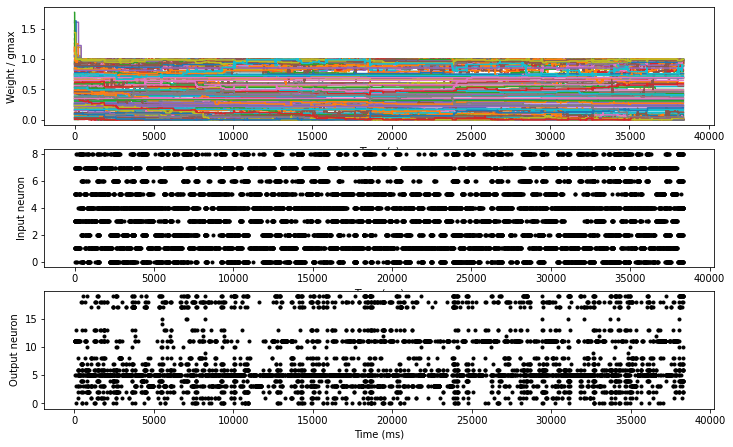

In [ ]:
plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(mon_stdp.t/b2.ms, mon_stdp.w.T/gmax)
plt.xlabel('Time (s)')
plt.ylabel('Weight / gmax')
plt.subplot(412)
plt.plot(mon_input.t/b2.ms, mon_input.i, '.k')
plt.xlabel('Time (ms)')
plt.ylabel('Input neuron')
plt.subplot(413)
plt.plot(mon_exc.t/b2.ms, mon_exc.i, '.k')
plt.xlabel('Time (ms)')
plt.ylabel('Output neuron')
plt.show()

## Назначаем классы нейронам
Предъявляем сети по очереди изображения. Для каждого изображения подсчитываем количество спайков от каждого нейрона и сохраняем в массив.
Затем каждому нейрону назначаем класс в зависимости от того, на какой класс изображений он был больше всего активен.

[1 0 1 0 1 3 1 1 0 1 1 2 0 1 1 1 0 1 1 1]
[[ 0.  0.  1. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 3.  0.  4. ...  1.  1.  1.]
 ...
 [ 0.  2.  0. ...  0.  5.  0.]
 [ 0.  0.  2. ...  1.  2.  2.]
 [ 1.  3.  5. ...  1.  1. 13.]]


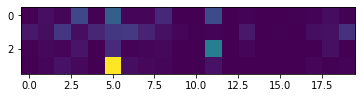

In [ ]:
def evaluate(X):
    img_rates = np.zeros((len(X), len(exc_layer)))
    T_show = 150*b2.ms
    rate_mon = b2.SpikeMonitor(exc_layer)
    prev_count = np.zeros((len(exc_layer), ))
    for i_img, img in enumerate(X):
        input_layer.rates = img.ravel()*max_rate
        b2.run(T_show, report=None)
        img_rates[i_img, :] = np.array(rate_mon.count-prev_count)
        prev_count += img_rates[i_img, :]
        input_layer.rates = img.ravel()*0*b2.Hz
        b2.run(T_rest, report=None)
    return img_rates
  
stdp_synapses.stdp_rate = 0
train_rates = evaluate(X_train)
nrn_class_count = np.zeros((len(patterns),len(exc_layer)))
for i_class in range(len(patterns)):
    nrn_class_count[i_class, :] = np.sum(train_rates[np.equal(y_train, i_class), :], axis=0)
plt.imshow(nrn_class_count)
neuron_class = np.argmax(nrn_class_count, axis=0)
print(neuron_class)
print(train_rates)

## Оценка точности классификации на тестовой выборке

In [ ]:
test_rates = evaluate(X_test)
print(test_rates)

[[ 0.  0.  1.  0.  0. 41.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  2.  1.  5.  0. 13.  1.  1.  2.  0.  0.  7.  0.  0.  0.  1.  0.  1.
   0.  0.]
 [ 0.  0.  1.  2.  0. 11.  1.  1.  2.  0.  0. 29.  0.  0.  0.  1.  0.  0.
   2.  0.]
 [ 0.  1.  3.  1.  0. 23.  4.  0.  0.  0.  0.  4.  0.  0.  0.  0.  0.  0.
   0.  1.]
 [ 0.  0.  3.  3.  0. 17.  4.  0.  0.  0.  2.  2.  0.  0.  0.  0.  0.  0.
   0.  2.]
 [ 0.  0.  1.  2.  0. 39.  1.  0.  3.  0.  0.  5.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  2.  0.  8.  0. 11.  0.  1.  4.  0.  0. 13.  0.  0.  0.  0.  1.  0.
   1.  0.]
 [ 0.  0.  0.  4.  0.  2.  0.  0.  0.  0.  0. 20.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  3.  0.  0. 16.  2.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.
   0.  1.]
 [ 0.  1.  0. 12.  0. 13.  0.  0.  1.  0.  0.  2.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  2.  1.  0.  3.  2.  1.  0.  0.  0. 17.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 1.  3.  5.  2.  7.  3.  6.  2.  4.  1.  0.  0.  0.  2.  0.  0.

[3. 3. 2. 3. 3. 3. 2. 2. 3. 3. 2. 1. 1. 3. 3. 3. 3. 3. 3. 2. 2. 2. 2. 1.
 2. 1. 1. 3. 1. 1. 3. 2. 3. 3. 1. 3. 3. 3. 2. 3. 3. 2. 2. 0. 0. 2. 2. 0.]
[3, 0, 2, 3, 3, 3, 0, 2, 3, 2, 2, 1, 1, 0, 1, 0, 3, 0, 3, 2, 2, 2, 2, 1, 2, 1, 1, 3, 1, 1, 3, 2, 0, 0, 1, 0, 0, 1, 2, 3, 0, 2, 2, 0, 0, 2, 2, 2]
Accuracy: 0.7083333333333334


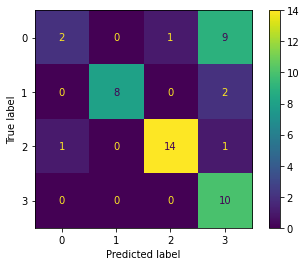

In [ ]:
def predict(rates, neuron_class):
    y = np.ones(rates.shape[0])*np.nan
    for i, x in enumerate(rates):
        y[i] = neuron_class[np.argmax(x)]
    return y

test_prediction = predict(test_rates, neuron_class)

print(test_prediction)
print(y_test)
acc = accuracy_score(y_test, test_prediction)
cm = confusion_matrix(y_test, test_prediction)
print(f"Accuracy: {acc}")
cm_display = ConfusionMatrixDisplay(cm).plot()